In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Text Classification Tutorial

This notebook demonstrates text classification with `TorchText`. The model and dataset are taken directly from the [PyTorch Text Classification Tutorial](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext.datasets import text_classification
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split

## STEP 1: Construct a Dataset

In [3]:
# Construct DataLoaders

NGRAMS = 2
import os
if not os.path.isdir('./.data'):
	os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return [text, offsets], label

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

train_loader = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
val_loader = DataLoader(sub_valid_, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=generate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=generate_batch)

120000lines [00:08, 14919.25lines/s]
120000lines [00:16, 7333.33lines/s]
7600lines [00:01, 7443.67lines/s]


## Construct a Model

In [4]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, data):
        text = data[0]
        offsets = data[1]
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)  
    
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

## STEP 3: Train with `TorchFit`

In [5]:
import torchfit
learner = torchfit.Learner(model, train_loader, val_loader=val_loader, 
                           optimizer=optimizer, loss=criterion, device=device)

In [6]:
hist = learner.fit(4.0, 3, schedulers=[scheduler])

Epoch 1 / 3
[========================================] 100%	  loss: 0.4196  accuracy: 0.9401  val_loss: 0.2948  val_accuracy: 0.9018

Epoch 2 / 3
[========================================] 100%	  loss: 0.1902  accuracy: 0.9666  val_loss: 0.2849  val_accuracy: 0.9057

Epoch 3 / 3
[========================================] 100%	  loss: 0.1097  accuracy: 0.9785  val_loss: 0.3200  val_accuracy: 0.9065



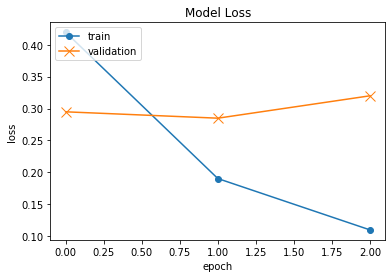

In [7]:
learner.plot('loss')

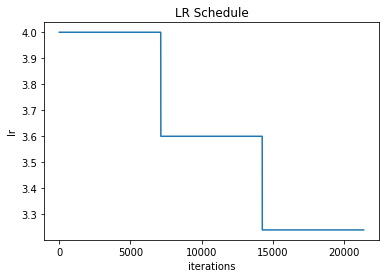

In [8]:
learner.plot('lr')

## STEP 4:  Making Predictions

In [10]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
vocab = train_dataset.get_vocab()

labels = ['World', 'Sports', 'Business', 'Sci/Tech']

def preprocess(text):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), 2)])
        return [text, torch.tensor([0])]

text = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

prediction = learner.predict_example(text, preproc_fn=preprocess, labels=labels)
print('predicted topic: %s' % prediction)

predicted topic: Sports
